<a href="https://colab.research.google.com/github/kokot123-dev/MISP/blob/main/zaj6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pulp

!sudo apt-get install coinor-cbc glpk-utils coinor-clp

Reading package lists... Done
Building dependency tree       
Reading state information... Done
coinor-cbc is already the newest version (2.9.9+repack1-1).
coinor-clp is already the newest version (1.16.11+repack1-1).
glpk-utils is already the newest version (4.65-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


# **PROBLEM**

Wypełnij kalendarz zmian, minimalizując wartość wypłaty

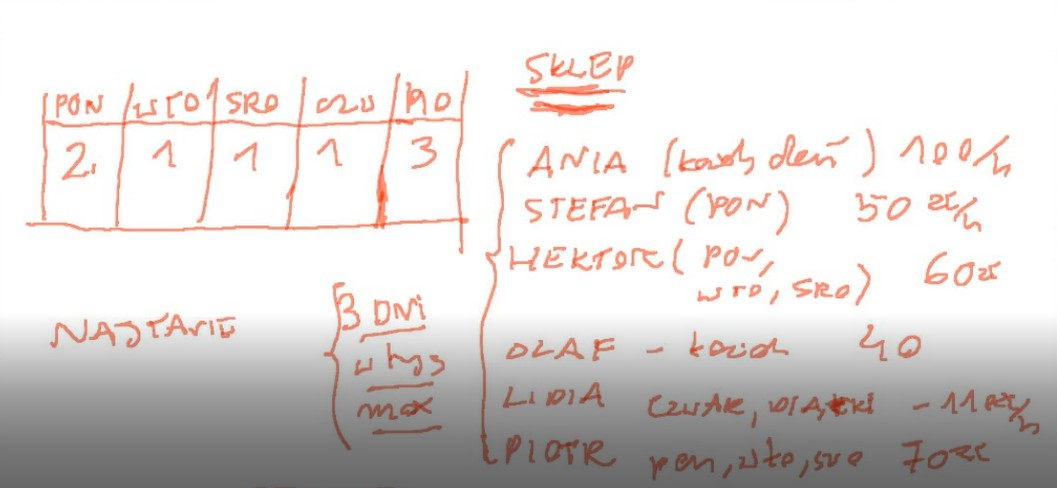

# Kroki analizowania problemu

Identyfikacja zmiennych decyzyjnych

Określenie funkcji celu

Określenie ograniczeń

Rozwiązanie problemu

**Zmienne decyzyjne**

kto kiedy jest dostępny 


```LpVariable.dicts("vars",(pracownicy.keys(), dni),lowBound=0,upBound=1,cat='Integer')```


**Funkcja celu**

minimalizacja wypłaty

```lpSum(pracownicy[pracownik]["stawka"]•lpSum(vars[pracownik][dzien] for dzien in dni) for pracownik in pracownicy)```

**Ograniczenia**

* pracownik może pracować min raz w tyg oraz max 3 razy w tyg

```for pracownik in pracownicy:  prob += lpSum(vars[pracownik][dzien] for dzien in dni) <= 3  prob += lpSum(vars[pracownik][dzien] for dzien in dni) >= 1  ```

* pracownik może pracować tylko w dzień kiedy kiedy jest dostępny

```for pracownik in pracownicy: temp = 0  for dzien in dni:    if dzien not in pracownicy[pracownik]["dostepnosc"]:          temp += vars[pracownik][dzien]  prob += temp == 0```

* zapotrzebowanie osób w konkretne dni tygodnia

```for dzien in dni: prob += lpSum(vars[pracownik][dzien] for pracownik in pracownicy) >= liczba_osob[dzien]```

# Rozwiązanie problemu za pomocą biblioteki pulp

In [ ]:
from pulp import *
import pandas as pd

prob = LpProblem("problem_1000",LpMinimize)

pracownicy = {"ania"  :{"stawka":100*4, "dostepnosc":["pn","wt","sr","czw","pt"]},      #4h trwa zmiana więc x4 stawka godzinowa
              "stefan":{"stawka":50 *4,  "dostepnosc":["pn"]},
              "hektor":{"stawka":60 *4,  "dostepnosc":["pn","wt","sr"]},
              "olaf"  :{"stawka":40 *4,  "dostepnosc":["pn","wt","sr","czw","pt"]},
              "lidia" :{"stawka":11 *4,  "dostepnosc":["czw","pt"]},
              "piotr" :{"stawka":70 *4,  "dostepnosc":["pn","wt","sr"]}
              }

liczba_osob = {"pn":2,"wt":1,"sr":1,"czw":1,"pt":3}
dni = ["pn","wt","sr","czw","pt"]

vars = LpVariable.dicts("vars",(pracownicy.keys(), dni),lowBound=0,upBound=1,cat='Integer')

prob += lpSum(pracownicy[pracownik]["stawka"]*lpSum(vars[pracownik][dzien] for dzien in dni) for pracownik in pracownicy) #min wypłaty

for pracownik in pracownicy:
  temp = 0
  for dzien in dni:
    if dzien not in pracownicy[pracownik]["dostepnosc"]:    #ograniczenie dostepnosci w tygodniu
      temp += vars[pracownik][dzien]
  prob += temp == 0

for dzien in dni:
  prob += lpSum(vars[pracownik][dzien] for pracownik in pracownicy) >= liczba_osob[dzien]   #ograniczenie min osób danego dnia

for pracownik in pracownicy:
  prob += lpSum(vars[pracownik][dzien] for dzien in dni) <= 3
  prob += lpSum(vars[pracownik][dzien] for dzien in dni) >= 1   #ograniczenie min/max przepracownych dni

prob.solve()
print("Status:", LpStatus[prob.status], "\n")
print("Wypłata wynosi:", value(prob.objective), "zł", "\n")

output = []
for pracownik in pracownicy:
  output.append([int(vars[pracownik][dzien].varValue) for dzien in dni])

output_df = pd.DataFrame(output, columns = dni, index = pracownicy.keys())
output_df

Status: Optimal 

Wypłata wynosi: 1528.0 zł 



,pn,wt,sr,czw,pt
ania,0,0,0,0,1
stefan,1,0,0,0,0
hektor,0,1,0,0,0
olaf,1,0,0,0,1
lidia,0,0,0,1,1
piotr,0,0,1,0,0
